In [1]:
import torch
torch.manual_seed(320)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torchvision
import numpy as np
import pylab as plt

import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix


def fgsm_attack(image: torch.Tensor, epsilon: float, data_grad: torch.Tensor) -> torch.Tensor:
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32), interpolation=0),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST('/mnt/data/MNIST', train=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('/mnt/data/MNIST', train=False, transform=transform)
test_dataset = torchvision.datasets.SVHN('/mnt/data/SVHN', transform=transform)

train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=7)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=7)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=7)

In [3]:
len(train_dataset), len(val_dataset), len(test_dataset)

(60000, 10000, 73257)

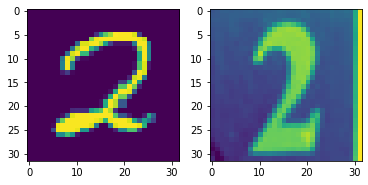

In [4]:
img1, label = val_dataset[35]
img2, _ = test_dataset[43]
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(img1[0])
ax[1].imshow(img2[0])
plt.show()

In [5]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.feature_ext = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(32, 48, 5),
            nn.MaxPool2d(2, 2),
            nn.ReLU()
        )
        self.clf = nn.Sequential(
            nn.Linear(48 * 5 * 5, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        x = self.feature_ext(x)
        x = x.view(-1, 48 * 5 * 5)
        x = self.clf(x)
        return x

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=2e-4, momentum=0.9, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

In [7]:
model.load_state_dict(torch.load('lenet.pth'))

<All keys matched successfully>

In [9]:
for epoch in range(14):
    model.train()
    for images, labels in tqdm(train_generator, total=len(train_generator)):
        images = images.to(device)
        labels = labels.to(device)
        
        #FGSM attack
        images.requires_grad = True
        prediciton = model(images)
        loss = criterion(prediciton, labels)
        model.zero_grad()
        loss.backward()
        images = fgsm_attack(images, 0.4, images.grad.data)
        
        optimizer.zero_grad()
        prediciton = model(images)
        loss = criterion(prediciton, labels)
        loss.backward()
        optimizer.step()
    model.eval()
    yp = np.array([])
    yt = np.array([])
    for images, labels in tqdm(val_generator, total=len(val_generator)):
        with torch.no_grad():
            prediciton = model(images.to(device))
        p = prediciton.argmax(dim=1).cpu().numpy()
        yp = np.concatenate((yp, p))
        yt = np.concatenate((yt, labels.numpy()))
    print(classification_report(yt, yp))

  0%|          | 0/469 [00:00<?, ?it/s]

             precision    recall  f1-score   support

        0.0       0.85      1.00      0.91       980
        1.0       0.70      0.98      0.81      1135
        2.0       0.56      0.49      0.52      1032
        3.0       0.57      0.47      0.52      1010
        4.0       0.78      0.83      0.81       982
        5.0       0.89      0.26      0.40       892
        6.0       0.75      0.91      0.82       958
        7.0       0.73      0.88      0.80      1028
        8.0       0.61      0.41      0.49       974
        9.0       0.69      0.78      0.73      1009

avg / total       0.71      0.71      0.68     10000



  0%|          | 0/469 [00:00<?, ?it/s]

             precision    recall  f1-score   support

        0.0       0.81      1.00      0.89       980
        1.0       0.73      0.98      0.84      1135
        2.0       0.66      0.39      0.49      1032
        3.0       0.59      0.61      0.60      1010
        4.0       0.77      0.80      0.78       982
        5.0       0.88      0.21      0.33       892
        6.0       0.71      0.90      0.79       958
        7.0       0.71      0.85      0.77      1028
        8.0       0.54      0.42      0.47       974
        9.0       0.65      0.74      0.69      1009

avg / total       0.70      0.70      0.67     10000



  0%|          | 0/469 [00:00<?, ?it/s]

             precision    recall  f1-score   support

        0.0       0.79      1.00      0.88       980
        1.0       0.79      0.98      0.88      1135
        2.0       0.70      0.46      0.56      1032
        3.0       0.57      0.75      0.65      1010
        4.0       0.76      0.79      0.77       982
        5.0       0.86      0.14      0.24       892
        6.0       0.80      0.88      0.84       958
        7.0       0.70      0.82      0.75      1028
        8.0       0.52      0.49      0.50       974
        9.0       0.66      0.67      0.66      1009

avg / total       0.71      0.71      0.68     10000



  0%|          | 0/469 [00:00<?, ?it/s]

             precision    recall  f1-score   support

        0.0       0.81      0.99      0.89       980
        1.0       0.83      0.98      0.90      1135
        2.0       0.71      0.58      0.64      1032
        3.0       0.60      0.76      0.67      1010
        4.0       0.75      0.72      0.73       982
        5.0       0.78      0.14      0.24       892
        6.0       0.78      0.89      0.83       958
        7.0       0.71      0.81      0.76      1028
        8.0       0.53      0.44      0.48       974
        9.0       0.61      0.69      0.65      1009

avg / total       0.71      0.71      0.69     10000



  0%|          | 0/469 [00:00<?, ?it/s]

             precision    recall  f1-score   support

        0.0       0.84      0.99      0.91       980
        1.0       0.88      0.98      0.93      1135
        2.0       0.69      0.71      0.70      1032
        3.0       0.67      0.76      0.71      1010
        4.0       0.69      0.69      0.69       982
        5.0       0.73      0.16      0.26       892
        6.0       0.72      0.91      0.80       958
        7.0       0.75      0.81      0.78      1028
        8.0       0.60      0.40      0.48       974
        9.0       0.59      0.70      0.64      1009

avg / total       0.72      0.72      0.70     10000



  0%|          | 0/469 [00:00<?, ?it/s]

             precision    recall  f1-score   support

        0.0       0.83      0.99      0.90       980
        1.0       0.88      0.99      0.93      1135
        2.0       0.75      0.73      0.74      1032
        3.0       0.78      0.66      0.71      1010
        4.0       0.65      0.52      0.58       982
        5.0       0.50      0.08      0.14       892
        6.0       0.75      0.91      0.82       958
        7.0       0.70      0.87      0.78      1028
        8.0       0.47      0.45      0.46       974
        9.0       0.54      0.75      0.63      1009

avg / total       0.69      0.71      0.68     10000



100%|██████████| 79/79 [00:00<00:00, 93.66it/s]

             precision    recall  f1-score   support

        0.0       0.82      0.99      0.90       980
        1.0       0.87      0.99      0.93      1135
        2.0       0.74      0.76      0.75      1032
        3.0       0.75      0.70      0.72      1010
        4.0       0.66      0.62      0.64       982
        5.0       0.54      0.18      0.27       892
        6.0       0.86      0.90      0.88       958
        7.0       0.76      0.85      0.80      1028
        8.0       0.54      0.51      0.52       974
        9.0       0.61      0.75      0.67      1009

avg / total       0.72      0.73      0.72     10000



In [10]:
model.load_state_dict(torch.load('al-lenet.pth'))

<All keys matched successfully>

100%|██████████| 573/573 [00:03<00:00, 166.62it/s]


             precision    recall  f1-score   support

        0.0       0.08      0.95      0.14      4948
        1.0       0.37      0.06      0.11     13861
        2.0       0.37      0.04      0.06     10585
        3.0       0.66      0.01      0.03      8497
        4.0       0.23      0.01      0.02      7458
        5.0       0.51      0.01      0.01      6882
        6.0       0.11      0.13      0.12      5727
        7.0       0.21      0.04      0.07      5595
        8.0       0.07      0.00      0.00      5045
        9.0       0.00      0.00      0.00      4659

avg / total       0.31      0.10      0.06     73257



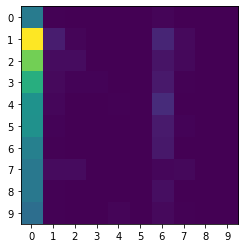

In [11]:
model.eval()
yp = np.array([])
yt = np.array([])
for images, labels in tqdm(test_generator, total=len(test_generator)):
    with torch.no_grad():
        prediciton = model(images.to(device))
    p = prediciton.argmax(dim=1).cpu().numpy()
    yp = np.concatenate((yp, p))
    yt = np.concatenate((yt, labels.numpy()))
print(classification_report(yt, yp))
plt.imshow(confusion_matrix(yt, yp))
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()

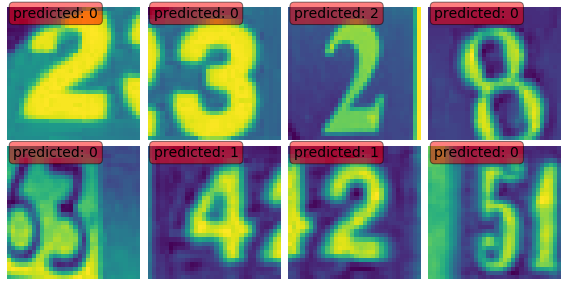

In [14]:
I = np.array([
    [2, 3, 43, 743],
    [25, 26, 27, 472]
])
Y = np.zeros_like(I)

fig, ax = plt.subplots(nrows=I.shape[0], ncols=I.shape[1], figsize=(10,5), gridspec_kw=dict(wspace=0.025, hspace=0.05))
for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        img, _ = test_dataset[I[i,j]]
        Y[i,j] = model(img.unsqueeze(0).to(device)).argmax(1).item()
        ax[i,j].axis('off')
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_aspect('equal')
        ax[i,j].imshow(img[0])
        ax[i,j].text(1,2,'predicted: %d' % Y[i,j], fontsize=14, bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
plt.show()
torch.save(model.state_dict(), 'al-lenet.pth')

In [15]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
])

target_transform_mnist = lambda x : torch.tensor(0)
target_transform_svhn = lambda x : torch.tensor(1)


a_dataset = torchvision.datasets.MNIST('/mnt/data/MNIST', train=True, transform=transform, target_transform=target_transform_mnist)
b_dataset = torchvision.datasets.SVHN('/mnt/data/SVHN', transform=transform, target_transform=target_transform_svhn)
mixed_dataset = torch.utils.data.ConcatDataset([a_dataset, b_dataset])
train_da_dataset, val_da_dataset = torch.utils.data.random_split(mixed_dataset, [100000, len(mixed_dataset) - 100000])

train_da_generator = torch.utils.data.DataLoader(train_da_dataset, batch_size=128, shuffle=True, num_workers=7)
val_da_generator = torch.utils.data.DataLoader(val_da_dataset, batch_size=128, shuffle=True, num_workers=7)

In [ ]:
len(train_da_dataset), len(val_da_dataset)

In [ ]:
batch = next(iter(train_da_generator))
batch[1]

In [ ]:
class GradReverse(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x):
        return x
    
    @staticmethod
    def backward(ctx, grad_output):
        return (-grad_output)


class DANet(nn.Module):
    
    def __init__(self, feature_ext):
        super().__init__()
        self.feature_ext = feature_ext
        self.grl = GradReverse.apply
        self.dc = nn.Sequential(
            nn.Linear(48 * 5 * 5, 100),
            nn.ReLU(),
            nn.Linear(100, 2),
        )

    def forward(self, x):
        x = self.feature_ext(x)
        x = self.grl(x)
        x = x.view(-1, 48 * 5 * 5)
        x = self.dc(x)
        return x

In [ ]:
da_model = DANet(model.feature_ext).to(device)
optimizer = torch.optim.SGD(da_model.parameters(), lr=2e-4, momentum=0.9, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(3):
    da_loss = 0.
    da_model.train()
    for images, labels in tqdm(train_da_generator, total=len(train_da_generator)):
        images = images.to(device)
        labels = labels.to(device)
        
        #FGSM attack
        images.requires_grad = True
        prediciton = model(images)
        loss = criterion(prediciton, labels)
        model.zero_grad()
        loss.backward()
        images = fgsm_attack(images, -0.4, images.grad.data)
        
        optimizer.zero_grad()
        prediciton = da_model(images)
        loss = criterion(prediciton, labels)
        loss.backward()
        optimizer.step()
        da_loss += loss.item()
    da_model.eval()
    yp = np.array([])
    yt = np.array([])
    for images, labels in tqdm(val_da_generator, total=len(val_da_generator)):
        with torch.no_grad():
            prediciton = da_model(images.to(device))
        p = prediciton.argmax(dim=1).cpu().numpy()
        yp = np.concatenate((yp, p))
        yt = np.concatenate((yt, labels.numpy()))
    print(da_loss)

In [ ]:
model.feature_ext = da_model.feature_ext
for param in model.feature_ext.parameters():
    param.requires_grad = False
optimizer = torch.optim.SGD(model.parameters(), lr=2e-4, momentum=0.9, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(2):
    loss_val = 0.
    model.train()
    for images, labels in tqdm(train_generator, total=len(train_generator)):
        images = images.to(device)
        labels = labels.to(device)
                        
        #FGSM attack
        images.requires_grad = True
        prediciton = model(images)
        loss = criterion(prediciton, labels)
        model.zero_grad()
        loss.backward()
        images = fgsm_attack(images, 0.4, images.grad.data)
        
        optimizer.zero_grad()
        prediciton = model(images)
        loss = criterion(prediciton, labels)
        loss.backward()
        optimizer.step()
        loss_val += loss.item()
    model.eval()
    yp = np.array([])
    yt = np.array([])
    for images, labels in tqdm(val_generator, total=len(val_generator)):
        with torch.no_grad():
            prediciton = model(images.to(device))
        p = prediciton.argmax(dim=1).cpu().numpy()
        yp = np.concatenate((yp, p))
        yt = np.concatenate((yt, labels.numpy()))
    print(loss_val)

In [ ]:
model.eval()
yp = np.array([])
yt = np.array([])
for images, labels in tqdm(val_generator, total=len(val_generator)):
    with torch.no_grad():
        prediciton = model(images.to(device))
    p = prediciton.argmax(dim=1).cpu().numpy()
    yp = np.concatenate((yp, p))
    yt = np.concatenate((yt, labels.numpy()))
print(classification_report(yt, yp))

In [ ]:
model.eval()
yp = np.array([])
yt = np.array([])
for images, labels in tqdm(test_generator, total=len(test_generator)):
    with torch.no_grad():
        prediciton = model(images.to(device))
    p = prediciton.argmax(dim=1).cpu().numpy()
    yp = np.concatenate((yp, p))
    yt = np.concatenate((yt, labels.numpy()))
print(classification_report(yt, yp))
plt.figure(figsize=(2,2))
plt.imshow(confusion_matrix(yt, yp))
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()

In [ ]:
I = np.array([
    [2, 3, 43, 743],
    [25, 26, 27, 472]
])
Y = np.zeros_like(I)

fig, ax = plt.subplots(nrows=I.shape[0], ncols=I.shape[1], figsize=(10,5), gridspec_kw=dict(wspace=0.025, hspace=0.05))
for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        img, _ = test_dataset[I[i,j]]
        Y[i,j] = model(img.unsqueeze(0).to(device)).argmax(1).item()
        ax[i,j].axis('off')
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_aspect('equal')
        ax[i,j].imshow(img[0])
        ax[i,j].text(1,2,'predicted: %d' % Y[i,j], fontsize=14, bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
plt.show()
torch.save(model.state_dict(), 'daal-lenet.pth')

In [ ]:
net = Net().to(device).eval()
net.load_state_dict(torch.load('al-lenet.pth'))

I = np.array([
    [2, 3, 43, 743],
    [25, 26, 27, 472]
])
Y = np.zeros_like(I)

fig, ax = plt.subplots(nrows=I.shape[0], ncols=I.shape[1], figsize=(10,5), gridspec_kw=dict(wspace=0.025, hspace=0.05))
for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        img, _ = test_dataset[I[i,j]]
        Y[i,j] = net(img.unsqueeze(0).to(device)).argmax(1).item()
        ax[i,j].axis('off')
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_aspect('equal')
        ax[i,j].imshow(img[0])
        ax[i,j].text(1,3,'predicted: %d' % Y[i,j], fontsize=14, bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
plt.show()

net.eval()
yp = np.array([])
yt = np.array([])
for images, labels in tqdm(test_generator, total=len(test_generator)):
    with torch.no_grad():
        prediciton = net(images.to(device))
    p = prediciton.argmax(dim=1).cpu().numpy()
    yp = np.concatenate((yp, p))
    yt = np.concatenate((yt, labels.numpy()))
plt.figure(figsize=(2,2))
plt.imshow(confusion_matrix(yt, yp))
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()
print(classification_report(yt, yp))

In [ ]:
net = Net().to(device).eval()
net.load_state_dict(torch.load('daal-lenet.pth'))

I = np.array([
    [2, 3, 43, 743],
    [25, 26, 27, 472]
])
Y = np.zeros_like(I)

fig, ax = plt.subplots(nrows=I.shape[0], ncols=I.shape[1], figsize=(10,5), gridspec_kw=dict(wspace=0.025, hspace=0.05))
for i in range(I.shape[0]):
    for j in range(I.shape[1]):
        img, _ = test_dataset[I[i,j]]
        Y[i,j] = net(img.unsqueeze(0).to(device)).argmax(1).item()
        ax[i,j].axis('off')
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_aspect('equal')
        ax[i,j].imshow(img[0])
        ax[i,j].text(1,2,'predicted: %d' % Y[i,j], fontsize=14, bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))
plt.show()

net.eval()
yp = np.array([])
yt = np.array([])
for images, labels in tqdm(test_generator, total=len(test_generator)):
    with torch.no_grad():
        prediciton = net(images.to(device))
    p = prediciton.argmax(dim=1).cpu().numpy()
    yp = np.concatenate((yp, p))
    yt = np.concatenate((yt, labels.numpy()))
plt.figure(figsize=(2,2))
plt.imshow(confusion_matrix(yt, yp))
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()
print(classification_report(yt, yp))